# Basic regression using the GPR model

GMRF (Gaussian Markov Random Fields) correspond to Gaussian Process models that are parametrised by the inverse of the covariance: the precision.

This notebook explains how to use Markovflow to build and optimise a GP regression model for a time series. **NOTE:** Markovflow does not require that the observations in a time series are regularly spaced.

In [1]:
# Setup
import warnings
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf

from gpflow import default_float
from gpflow.ci_utils import ci_niter

from markovflow.kernels import Matern32
from markovflow.models import GaussianProcessRegression

FLOAT_TYPE = default_float()

# Turn off warnings
warnings.simplefilter('ignore')

try:
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')
except AttributeError:
    print('Magic function can only be used in IPython environment')
    matplotlib.use('Agg')

plt.rcParams["figure.figsize"] = [15, 8]

2022-07-26 11:53:00.117782: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-07-26 11:53:00.117815: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Step 1: Generate training data
Usually it is a good idea to normalise the data, because by default most kernels revert to a mean of zero.

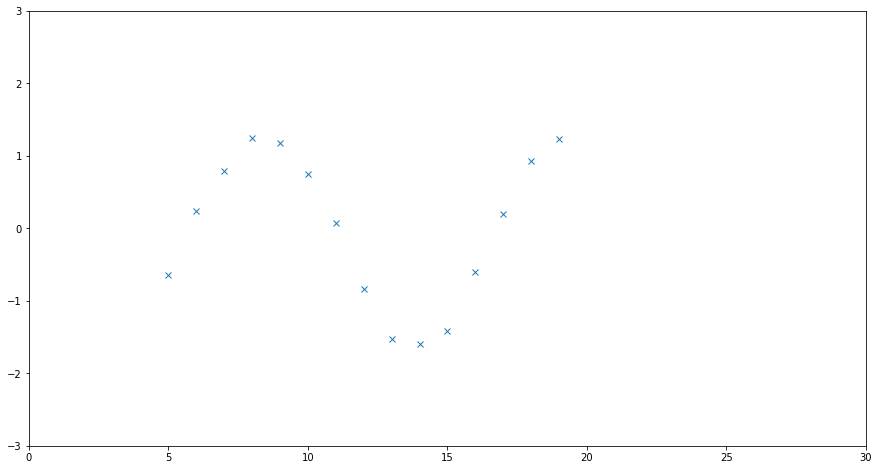

In [2]:
def create_observations(time_points: np.ndarray) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    A helper function to create training data.
    :param time_points: Points in time.
    :return: Tuple[x,y] Data that represents the observation shapes:
        X = [num_points, 1],
        Y = [num_points, state_dim , 1] where state_dim is currently 1
    """
    observations = np.sin(12 * time_points[..., None])
    observations += np.random.randn(len(time_points), 1) * 0.1
    observations += 3
    return time_points, observations

# Generate some observations
time_points, observations = create_observations(np.arange(5.0, 20.0))

# Usually it is a good idea to normalise the data, because by default most kernels revert to a mean of zero
norm_observations = (observations - np.mean(observations)) / np.std(observations)

plt.plot(time_points.squeeze(), norm_observations.squeeze(), 'C0x')
plt.xlim((0., 30.))
plt.ylim((-3., 3.))
plt.show()

## Step 2: Choose a kernel and create the model
Markovflow provides several SDE (Stochastic Differential Equation) kernels. Your domain knowledge is encoded in your choice of kernel, or combination of kernels. For more information, see
[Choosing and combining kernels](./choosing_and_combining_kernels.ipynb).

In this example we use a Matern 1/2 kernel. However, given our knowledge of the data, a periodic kernel might be more appropriate. Why not try it?

We also use an observation covariance of 0.001. The observation covariance is the amount of noise that we believe exists in our observations (the measurement noise).

**NOTE:** In this example `observation_covariance` is not set as trainable.  This is the equivalent of specifying a specific value for the measurement noise. Try varying the magnitude of this parameter, or making it trainable.

In [3]:
# Add some noise to the observations
observation_covariance = tf.constant([[0.0001]], dtype=FLOAT_TYPE)

# Create a GPR model
kernel = Matern32(lengthscale=8.0, variance=1.0)
input_data = (tf.constant(time_points), tf.constant(norm_observations))
gpr = GaussianProcessRegression(input_data=input_data, kernel=kernel,
                                chol_obs_covariance=tf.linalg.cholesky(observation_covariance))

2022-07-26 11:53:01.777945: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-26 11:53:01.778150: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-07-26 11:53:01.778161: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-26 11:53:01.778184: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az99-674): /proc/driver/nvidia/version does not exist
2022-07-26 11:53:01.778434: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FM

We can calculate the marginal likelihood (that is, the probability of the observed data given the model) before we optimise the model.
**NOTE:** We are using log likelihood, so a probability of 1.0 (the data definitely came from the model) is equal to a log likelihood of zero (with lower probabilities increasingly negative).

In [4]:
# Before optimisation, calculate the log likelihood of the observations given the current kernel parameters 
print(gpr.log_likelihood())

tf.Tensor(-25.613000164014196, shape=(), dtype=float64)


After optimisation, the probability of the data given the model should have increased (that is, the log likelihood should have increased).

In [5]:
opt = tf.optimizers.Adam()

@tf.function
def opt_step():
    opt.minimize(gpr.loss, gpr.trainable_variables)

max_iter = ci_niter(4000)
for _ in range(max_iter):
    opt_step()

print(gpr.log_likelihood())

2022-07-26 11:53:01.862758: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-07-26 11:53:04.041562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-26 11:53:04.056247: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz


tf.Tensor(-5.681508434258994, shape=(), dtype=float64)


## Step 3: Generate a mean for the training data
We can use the model's posterior `predict_f` function to get the mean of the true function values (observations without noise).

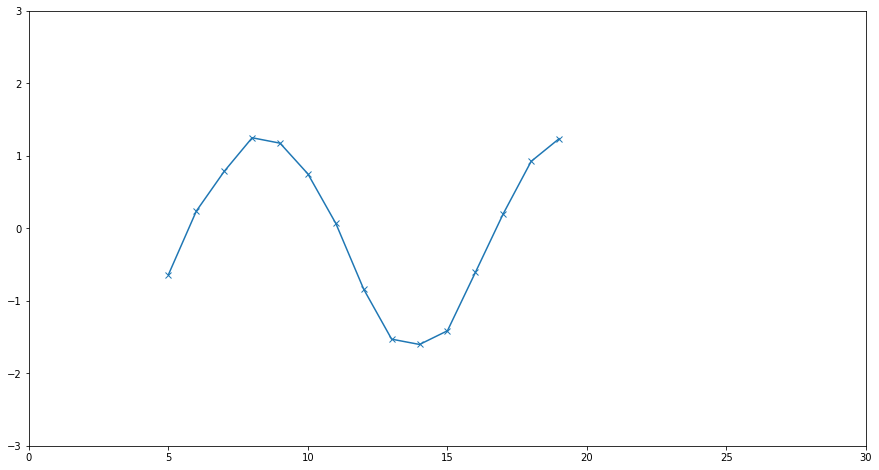

In [6]:
mean, _ = gpr.posterior.predict_f(gpr.time_points)
# Plot the results
plt.plot(time_points, norm_observations, 'C0x')
plt.plot(time_points, mean, mew=2)
plt.xlim((0., 30.))
plt.ylim((-3., 3.))
plt.show()

## Step 4: Make a prediction for the future
The GPR model's `posterior` supports interpolation and extrapolation of the underlying state-space model.

For example, the `gpr.posterior.predict_f` function predicts means and covariances for the specified time points.

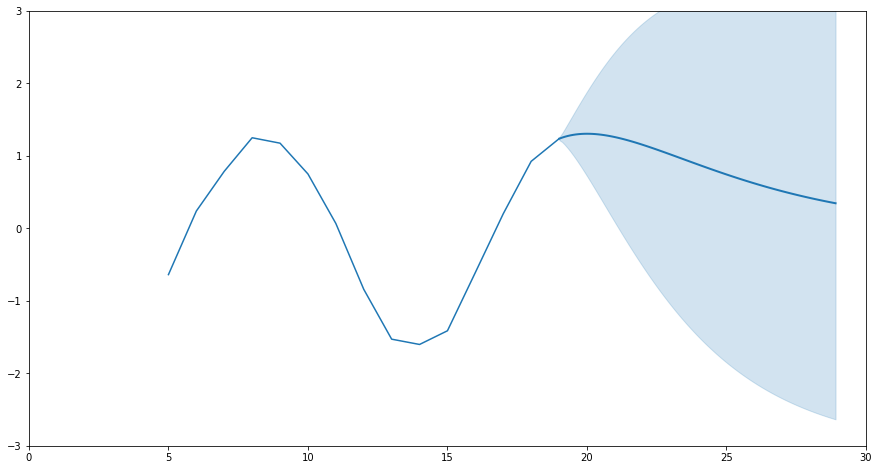

In [7]:
# Generate some time points in the future
future_time_points = np.arange(time_points[-1] + 0.01, time_points[-1] + 10.0, 0.1)

predicted_mean, predicted_cov = \
    gpr.posterior.predict_f(tf.constant(future_time_points, dtype=FLOAT_TYPE))
predicted_mean, predicted_cov = predicted_mean.numpy(), predicted_cov.numpy()

# Plot the means and covariances for these future time points
plt.plot(time_points, mean, mew=2)
plt.plot(future_time_points, predicted_mean, 'C0', lw=2)
plt.fill_between(future_time_points,
                 predicted_mean[:, 0] - 2 * np.sqrt(predicted_cov[:, 0]),
                 predicted_mean[:, 0] + 2 * np.sqrt(predicted_cov[:, 0]),
                 color='C0', alpha=0.2)
plt.xlim((0., 30.))
plt.ylim((-3., 3.))
plt.show()

The `gpr.posterior.sample_f` function samples from the posterior probability distribution. Note the variance of the initial points of the generated sampled trajectories. This is a result of the observation covariance we specified earlier.

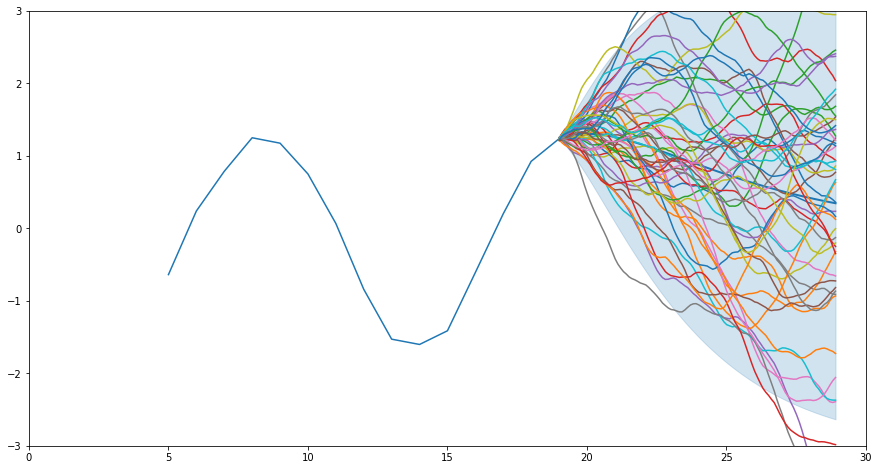

In [8]:
samples = gpr.posterior.sample_f(tf.constant(future_time_points, dtype=FLOAT_TYPE), 50)

# Plot the same as previous
plt.plot(time_points, mean, mew=2)
plt.plot(future_time_points, predicted_mean, 'C0', lw=2)
plt.fill_between(future_time_points,
                 predicted_mean.squeeze() - 2 * np.sqrt(predicted_cov.squeeze()),
                 predicted_mean.squeeze() + 2 * np.sqrt(predicted_cov.squeeze()),
                 color='C0', alpha=0.2)
# Add the samples
plt.plot(future_time_points[..., None], np.swapaxes(samples, 0, 1).squeeze())
plt.xlim((0., 30.))
plt.ylim((-3., 3.))
plt.show()

## Step 5: Show a history of confidence levels
The `gpr.posterior.predict_f` gets the posterior of the latent function at arbitrary time points.
To demonstrate this, we can generate a set of time points that begin before the training data and
extend them into the future. Note how the model is very certain about the fit in the region where there
is data (the confidence intervals are small), whereas the uncertainty grows when we predict in the future.

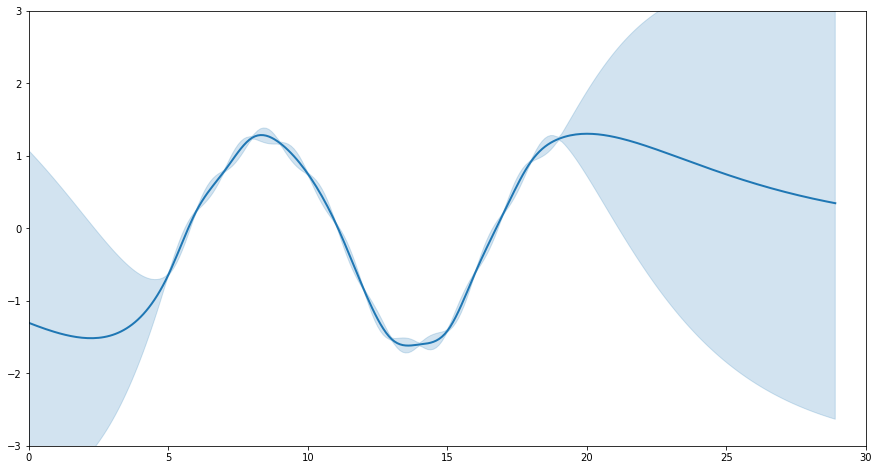

In [9]:
# Generate some other time points to evaluate
intermediate_time_points = np.arange(0.0, time_points[-1] + 10.0, 0.1)
predicted_mean, predicted_cov = \
    gpr.posterior.predict_f(tf.constant(intermediate_time_points, dtype=FLOAT_TYPE))
predicted_mean, predicted_cov = predicted_mean.numpy(), predicted_cov.numpy()

# Plot the results
plt.plot(intermediate_time_points, predicted_mean, 'C0', lw=2)
plt.fill_between(intermediate_time_points,
                 predicted_mean.squeeze() - 2 * np.sqrt(predicted_cov.squeeze()),
                 predicted_mean.squeeze() + 2 * np.sqrt(predicted_cov.squeeze()),
                 color='C0', alpha=0.2)
plt.xlim((0., 30.))
plt.ylim((-3., 3.))
plt.show()

## Step 6: Observe more data in the future
When new data becomes available, we can see how the variance collapses (the confidence increases) at the new point (`t=23`).

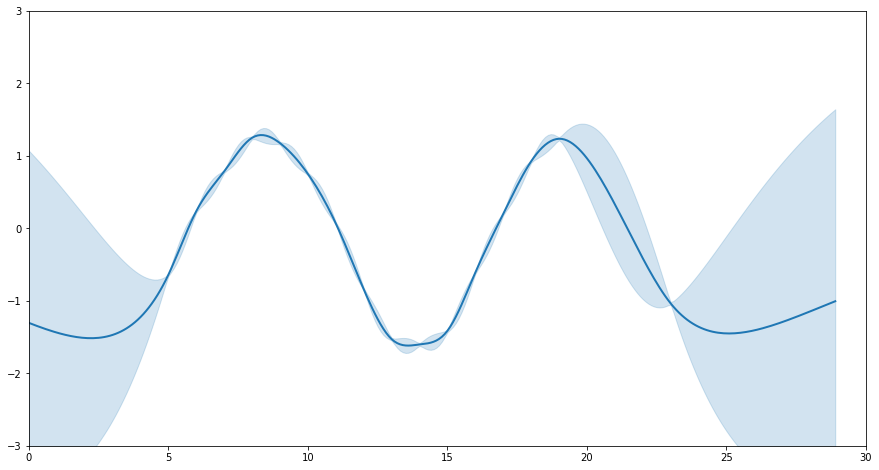

In [10]:
new_time, new_ob = create_observations(np.array([23.]))
# Normalise the new point based on the original observation's mean and std
new_ob = (new_ob - np.mean(observations)) / np.std(observations)
time_points = np.concatenate([time_points, new_time], axis=0)
new_observations = np.concatenate([norm_observations, new_ob], axis=0)

gpr._time_points = tf.constant(time_points)
gpr._observations = tf.constant(new_observations)

predicted_mean, predicted_cov = \
    gpr.posterior.predict_f(tf.constant(intermediate_time_points, dtype=FLOAT_TYPE))
# Plot the results
plt.plot(intermediate_time_points, predicted_mean, 'C0', lw=2)
plt.fill_between(intermediate_time_points,
                 predicted_mean[:, 0] - 2 * np.sqrt(predicted_cov[:, 0]),
                 predicted_mean[:, 0] + 2 * np.sqrt(predicted_cov[:, 0]),
                 color='C0', alpha=0.2)
plt.xlim((0., 30.))
plt.ylim((-3., 3.))
plt.show()